# Guide to how it works
The function simulate(config, L,nDim, eqSteps, err_runs,T) simulates the internal energy, magnetisation, specific heat capacity and magnetic susceptibility of a given lattice size, L, of number of dimensions, nDim (subject to periodic boundary conditions), for a given temperature (T can be a single value or an array).

It returns the aforementioned physical quantities along with the error bars for Energy (Err_E)

The important parameters for this code are:

<br> L          Lattice length 
<br>nDim        number of dimensions
<br>Nb         number of blocks
<br>mcSteps     number of Monte Carlo steps
<br>eqSteps     number of equilibration steps (first few runs cut off)
<br>err_runs    number of 
<br> 
<br> 

In [1]:
#Import essential modules
import numpy as np  # package for arrays
import matplotlib.pyplot as plt  # package for plotting
import time  # for timing
import random #generating random numbers
import math
import csv #for storing and retrieveing data
%matplotlib inline
plt.style.use("seaborn-dark")
plt.style.use("default")
#### for nDim dimensions #####

def init(L,nDim):
        N = L**nDim #number of lattice sites for a hypercubic lattice of dimension nDim 
        state = 2 * np.random.randint(2, size=(N,1)) - 1
        return state

def index(L,nDim):
    
        N = L**nDim
        ns = np.transpose(np.linspace(0,N-1,N))
        Indices = np.zeros((N,2*nDim))

        for ndim in range(1,nDim+1):
            rangminus = np.linspace(0,L**(ndim-1)-1,num = L**(ndim-1))
            rangplus = np.linspace(L**ndim - L**(ndim-1) ,L**(ndim)-1, num = L**(ndim-1))

            for n in range(N):
                 if ndim ==1:
                    if n%L == 0: 
                        #print("{} has a boundary in the negative direction".format(i))
                        nminus = n + L -1
                    else: 
                        nminus = n -1
                    if n%L == L-1:
                        #print("{} has a boundary in the negative direction".format(i))
                        nplus = n - L + 1
                    else:
                        nplus = n + 1
                 else: #only works for ndim >1
                        result = (L**ndim- n - 1)%L**(ndim)
                        if result in rangplus:
                            nminus = n + (L-1)*L**(ndim - 1)
                        else: 
                            nminus = n - L**(ndim-1)
                        if result in rangminus:
                            nplus = n - L**(ndim - 1)*(L-1)
                        else: 
                            nplus = n + L**(ndim-1)
                 Indices[n,2*(ndim-1)] = int(nminus)
                 Indices[n,2*ndim-1] = int(nplus)

        return(Indices)

#The Blocking Method Code mine & Erik

def BlockAv(data,Nb):  #Nb is the number of blocks
    
    # Function that calculates the error bar on the Nb blocks of a dataset with Ndata correlated data points
    Ndata = len(data) #Number of data points
    nb = Ndata/Nb     #nb is the number of data points per block
    Blocks = np.array_split(data,Nb) #Changed from nb to Nb
    Averages = [np.mean(x) for x in Blocks]
    error = np.std(Averages) /np.sqrt(Nb) #block average = average of all data points #Group suggestion #1: Evaluate sigma using np.std
    return error            #Group suggestion #2: have this algorithnm only return the error

def dE(config,Indices,nDim,n): #Calculates the dE contribution
    En = 0                     #from all the nearest neighbours of lattice site n 
    spins = 0 
    N = len(config)

    for i in range(2*nDim):
        
        j = int(Indices[n,i]) #Returns the lattice site index j of the ith nearest neighbour to the spin site n
        spins = spins + config[j] #adds the spin of the jth lattice site 
    
    En = 2*J*config[n,0]*spins 
    return En

'Total energy for a configuration' #Version that doesn't use dE
def E_dimensionless(config,Indices,L):
    total_energy = 0
    N = len(config)
    for n in range(N):
        s = config[n]
        nb = 0
        for j in range(2*nDim):
            nb += config[int(Indices[n,j])] #the sum of all other spins 
        total_energy += -J*nb * s
    return (total_energy)/(2) #Division by 2 to avoid overcounting and to calculate the energy per lattice site

'Calculate magnetisaton' #Returns the average magnetisation, which will tend to 0 as the number of spins are balanced. 
def magnetization(config):
    Mag = np.sum(config)
    return Mag

def MC_step(config, beta, Energy):
    '''Monte Carlo move using Metropolis algorithm '''
    #Completes N lattice flips 
    N = len(config)
    for i in range(N-1): #This is computationally expensive for larger N
            n = np.random.randint(0, N-1) 
            sigma = config[n]
            del_E = dE(config,Indices,nDim,n)
           # print(del_E)
            if del_E < 0:
                sigma *= -1
                Energy += del_E
            elif random.uniform(0,1) < np.exp(-del_E*beta): 
                sigma *= -1
                Energy += del_E #Energy is not normalised

    return config,Energy

### Write some code to plot the 2D case

def plot_lattice(config):
    N = len(config)
    L = int(np.sqrt(N))
    lattice_2D = np.zeros((L,L))

    for n in range(N):
        i = int((n - (n%L))/L)
        j = n%L
        lattice_2D[i,j] = config[n]

    plt.figure(dpi = 144)
    imgplot = plt.imshow(lattice_2D)
    imgplot.set_interpolation('none')
    plt.xticks(range(L))
    plt.yticks(range(L))
    plt.show()

def Binder_Ratio(A_squared_mean,A):
    Q = A_squared_mean/(A**2)
    return Q

#Important Code: Returns the Observables, the delObservables (naive errors), and errors for a given range of temperatures 
def simulate(config, L,nDim, mcSweeps, eqSteps, err_runs,T,plot_config):
        
    if nDim != 2: #Only 2 dimensional visualisations can be plotted
        plot_config = False
    Indices = index(L,nDim)
    N = L**nDim
   # mcSteps = 1000        # number of MC steps 
    Nb = 10
    T_c = 2/math.log(1 + math.sqrt(2)) #Theoretical Critical Temperature
 
 # initialise all variables
    nt = len(T)
    E,M,C,X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
    C_theoric, M_theoric = np.zeros(nt), np.zeros(nt)
    delta_E,delta_M, delta_C, delta_X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
    Energies = np.zeros(nt)
    Magnetizations = np.zeros(nt)
    SpecificHeats = np.zeros(nt)
    Susceptibilities = np.zeros(nt)
    
    #Error bars
    Err_E = np.zeros(nt)
    Err_M = np.zeros(nt)
    Err_Cv = np.zeros(nt)
    Err_X = np.zeros(nt)
    Q = np.zeros(nt)
    deltam1 = np.zeros(nt)
    deltam2 = np.zeros(nt)
    ErrQ = np.zeros(nt)
    
    energy =  E_dimensionless(config,Indices,L) #Energy of the initial configuration
    for t in range(nt):
        
        beta = 1./T[t] #T in units of kB
        all_energies = np.zeros(mcSteps) #Save a list of all energies for this timestamp (Later consider replacing with an array)
        all_energies_squared = np.zeros(mcSteps)
        all_mag = np.zeros(mcSteps) 
        all_mag_squared =  np.zeros(mcSteps)

        # evolve the system to equilibrium
        for i in range(eqSteps):
            new_config,new_energy = MC_step(config, beta, energy)
            config,energy = new_config,new_energy
        # list of macroscopic properties
        Ez = np.zeros(err_runs)
        Cz = np.zeros(err_runs)
        Mz = np.zeros(err_runs)
        Xz = np.zeros(err_runs) 

        for j in range(err_runs):
            E = E_squared = M = M_squared = 0
            for i in range(mcSteps):
                config,energy = MC_step(config, beta, energy)
                
                'ATTEMPT TO FIX '
                #OBSERVABLES ARE NORMALISED
                all_energies[i] = energy/N # Divide by the number of lattice sites
                all_energies_squared[i] = all_energies[i]**2
                mag = abs(magnetization(config)) # calculate the abs total mag. at time stamp
                all_mag[i] = mag/N
                all_mag_squared[i] = all_mag[i]**2
                
            # mean (divide by total time steps)
            E_mean = np.average(all_energies)
            E_squared_mean = np.average(all_energies_squared)
            M_mean = np.average(all_mag)
            M_squared_mean = np.average(all_mag_squared)
            Energy = E_mean
            SpecificHeat = N*beta**2 * (E_squared_mean - E_mean**2)
            Magnetization = M_mean
            Susceptibility = N*beta * (M_squared_mean - M_mean**2)
            #Q[t] = Binder_Ratio(M_squared_mean,(M_mean))
            
            Ez[j] = Energy; Cz[j] = SpecificHeat; Mz[j] = Magnetization; Xz[j] = Susceptibility;
            
        if plot_config == True:
            plot_lattice(config) #remove this later
            print('Temperature = {}'.format(round(T[t],3)))
            print('Magnetisation = {}'.format(round(Magnetization,3)))

        Energies[t] = np.mean(Ez)/2 #Division by 2 for overcounting sites
        Err_E[t] = float(BlockAv(all_energies,Nb))
        Err_M[t] = float(BlockAv(all_mag,Nb))

        #Section dedicated to Cv error
        deltx = BlockAv(all_energies_squared,Nb) #remade using BlockAv
        delty = BlockAv(all_energies,Nb)
        Err_Cv[t] = float((beta**2)*np.sqrt(deltx**2 + delty**2))

        #Section dedicated to X error
        deltam1[t] = BlockAv(all_mag,Nb)
        deltam2[t] = BlockAv(all_mag_squared,Nb)

        Err_X[t] = float((beta)*np.sqrt(deltam2[t]**2+deltam1[t]**2)) #Pietro Method
      
        Magnetizations[t] = np.mean(Mz)
        SpecificHeats[t] = np.mean(Cz)  
        Susceptibilities[t] = np.mean(Xz) 
        Q[t] = Binder_Ratio(M_squared_mean,(M_mean))
       
        #ErrQ[t] = (1/M_squared_mean)*np.sqrt(deltam1[t]**2+(Q[t]*deltam2[t])**2)
        ErrQ[t] = np.sqrt((deltam2[t]/M_squared_mean)**2+(deltam1[t]/M_mean)**2)
    
    return (Energies,Magnetizations,SpecificHeats,Susceptibilities,Err_E,Err_M,Err_Cv,Err_X,Q,ErrQ)

For 20 temperature points
L = 4 done. N = 16 took 63.981 seconds


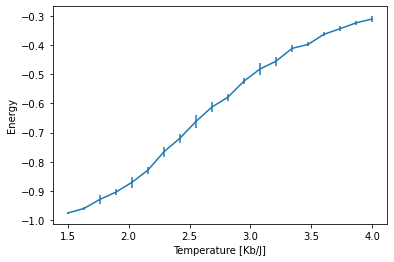

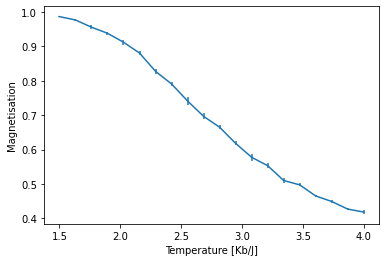

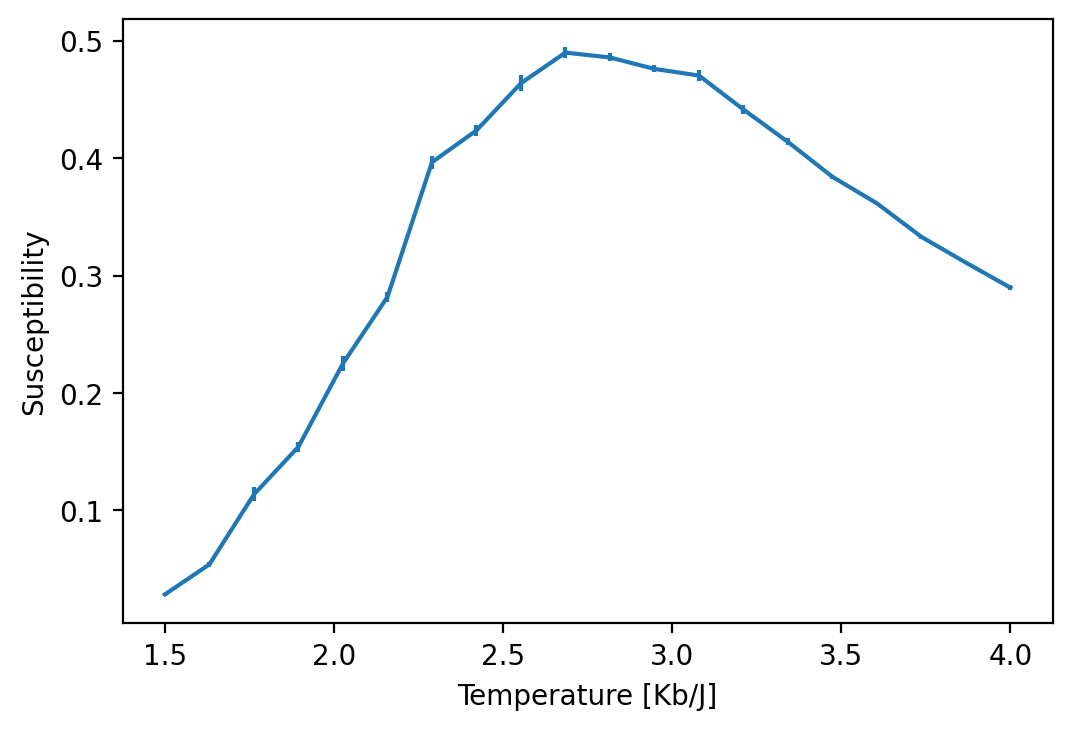

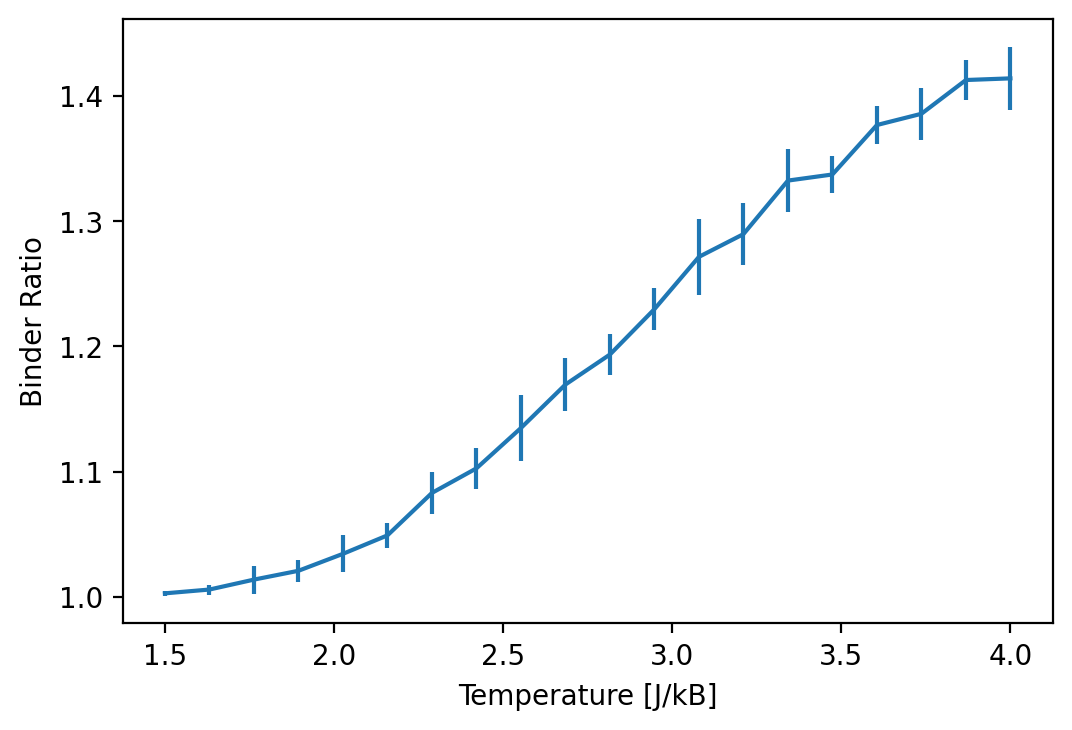

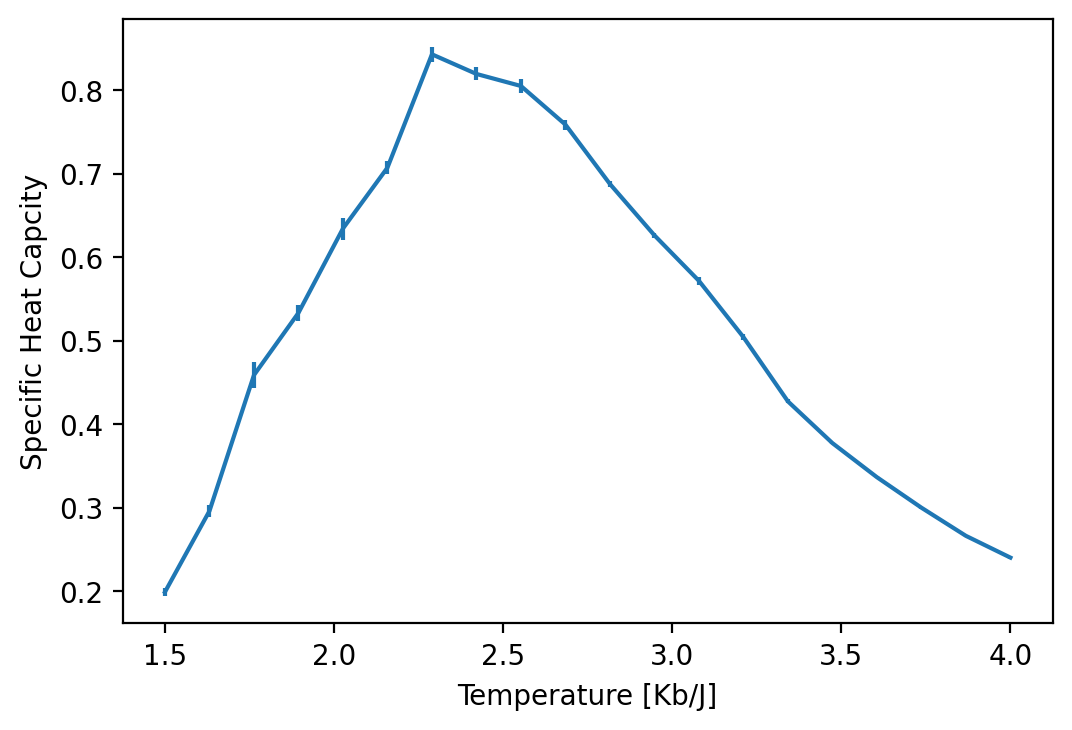

In [2]:
# Example of it in action
%matplotlib inline
nDim =2; L = 4
config = init(L,nDim)
Indices = index(L,nDim)

J = 1
eqSteps = 200; err_runs = 1; mcSteps = 10000
plot_config = False

Tmin = 1.5; Tmax = 4; nt = 20
T = np.linspace(Tmin, Tmax, nt)

print("For {} temperature points".format(nt))

start_time4 = time.time()
(E,Mag,Cv,X,Err_E,Err_M,Err_Cv,Err_X,Q,ErrQ) = \
    simulate(config, L,nDim, mcSteps, eqSteps, err_runs,T, plot_config)
end_time4 = time.time()
time4 =  round(end_time4-start_time4,3)
print("L = {} done. N = {} took {} seconds".format(L,L**nDim,time4))

plt.errorbar(T,E,yerr=Err_E,)
plt.ylabel('Energy')
plt.xlabel('Temperature [Kb/J]')
plt.show()

plt.errorbar(T,Mag,yerr=Err_M,)
plt.ylabel('Magnetisation')
plt.xlabel('Temperature [Kb/J]')
plt.show()

plt.figure(dpi = 200)
plt.errorbar(T,X,yerr=Err_X,)
plt.ylabel('Susceptibility')
plt.xlabel('Temperature [Kb/J]')
plt.show()


plt.figure(dpi=200)
plt.errorbar(T,Q,yerr=ErrQ)
plt.ylabel('Binder Ratio')
plt.xlabel('Temperature [J/kB]')
plt.show()

plt.figure(dpi = 200)
plt.errorbar(T,Cv,yerr=Err_Cv,)
plt.ylabel('Specific Heat Capcity')
plt.xlabel('Temperature [Kb/J]')
plt.show()

In [3]:
%matplotlib
plt.errorbar(T,Cv,yerr=Err_Cv,)
plt.ylabel('Specific Heat Capcity')
plt.xlabel('Temperature [Kb/J]')
plt.legend()
plt.show()

plt.figure(dpi = 200)
plt.errorbar(T,X,yerr=Err_X,)
plt.ylabel('Susceptibility')
plt.xlabel('Temperature [Kb/J]')
plt.legend()
plt.show()

plt.figure(dpi = 200)
plt.plot(T,Err_)
plt.ylabel('Susceptibility')
plt.xlabel('Temperature [Kb/J]')
plt.legend()
plt.show()

Using matplotlib backend: Qt5Agg


No handles with labels found to put in legend.
No handles with labels found to put in legend.


NameError: name 'Err_' is not defined

For L = 16, 4 temperature points


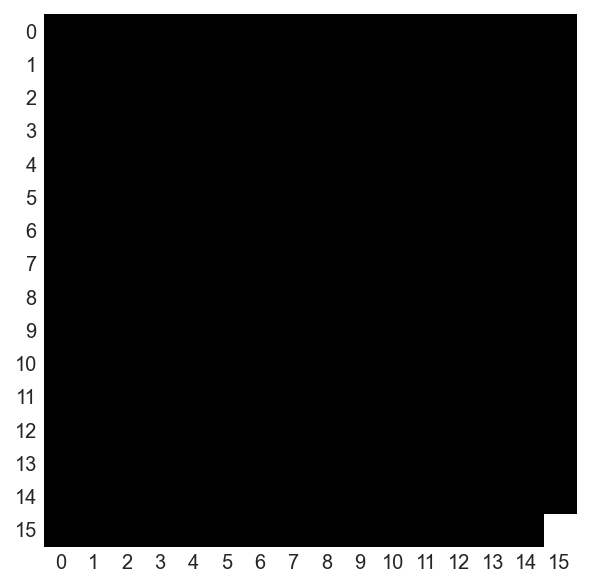

Temperature = 1.0
Magnetisation = 0.991


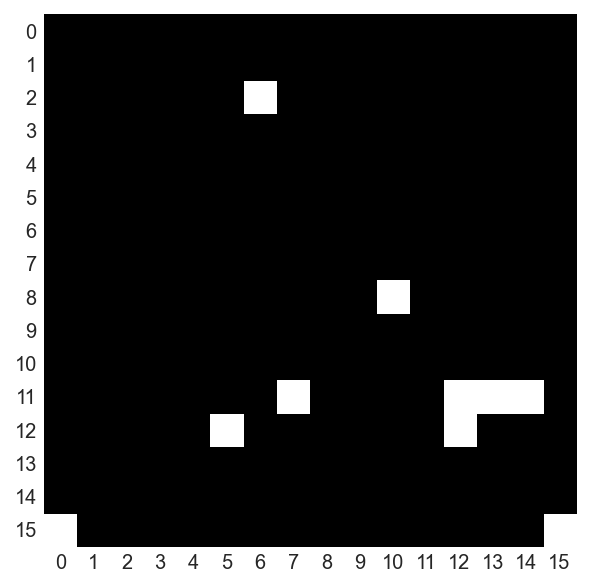

Temperature = 2.0
Magnetisation = 0.886


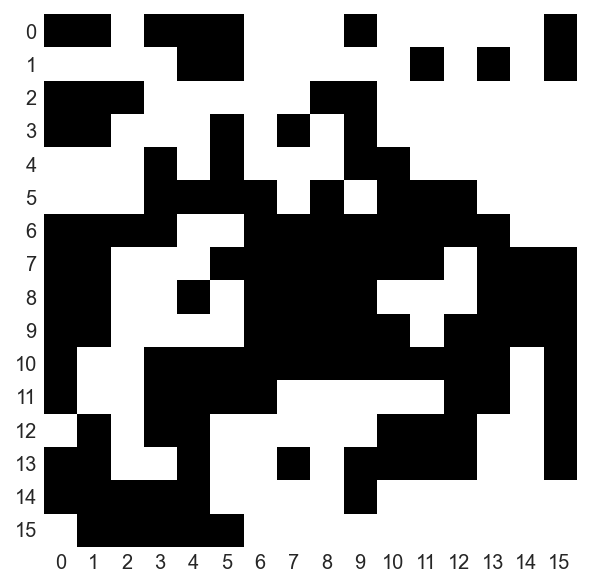

Temperature = 3.0
Magnetisation = 0.175


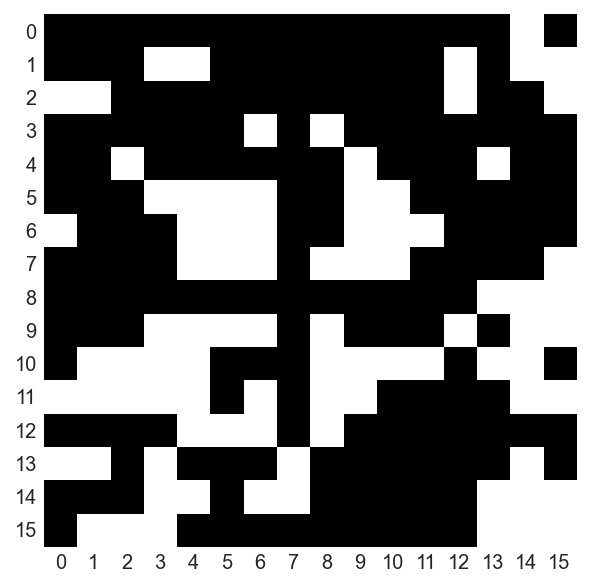

No handles with labels found to put in legend.


Temperature = 4.0
Magnetisation = 0.104
L = 16 done. N = 256 took 207.425 seconds


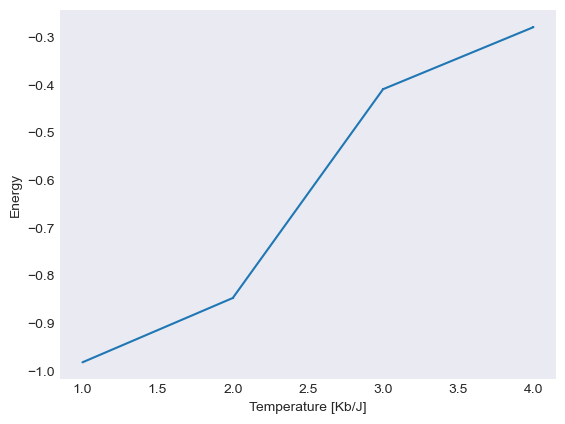

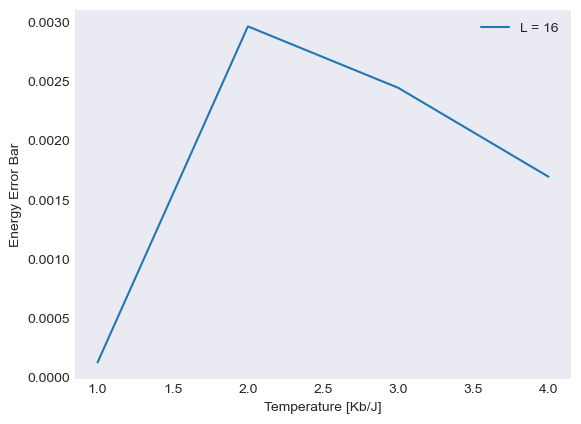

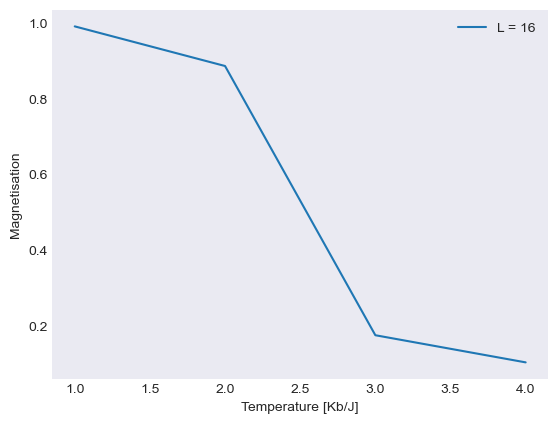

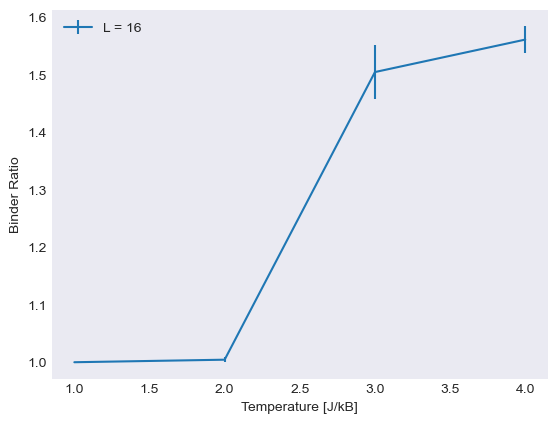

In [ ]:
'For an anti/ferromagnetic model '
plt.style.use("seaborn-dark")
nDim =2; plot_config = True  
L = 16
config = init(L,nDim); Indices = index(L,nDim)
J = 1 #or -1 for antiferro
eqSteps = 2000 ;err_runs = 1; mcSteps = 10000
Tmin = 1; Tmax = 4; nt = 4; T = np.linspace(Tmin, Tmax, nt)

config = init(L,nDim); Indices = index(L,nDim)

print("For L = {}, {} temperature points".format(L,nt))

start_time4 = time.time()
(E,Mag,Cv,X,Err_E,Err_M,Err_Cv,Err_X,Q,ErrQ) = \
    simulate(config, L,nDim, mcSteps, eqSteps, err_runs,T, plot_config)
end_time4 = time.time()
time4 =  round(end_time4-start_time4,3)
print("L = {} done. N = {} took {} seconds".format(L,L**nDim,time4))


plt.errorbar(T,E,yerr=Err_E,)
plt.ylabel('Energy')
plt.xlabel('Temperature [Kb/J]')
plt.legend()
plt.show()

plt.plot(T,Err_E, label = "L = {}".format(L))
plt.ylabel('Energy Error Bar')
plt.xlabel('Temperature [Kb/J]')
plt.legend()
plt.show()

plt.plot(T,Mag, label = "L = {}".format(L))
plt.ylabel('Magnetisation')
plt.xlabel('Temperature [Kb/J]')
plt.legend()
plt.show()

plt.errorbar(T,Q,yerr=ErrQ,label = "L = {}".format(L))
plt.ylabel('Binder Ratio')
plt.xlabel('Temperature [J/kB]')
plt.legend()
plt.show()

In [ ]:
' L = 4,8,16 & 32 '
J = 1; nDim = 2; plot_config = False #As before 
Tmin = 1.5; Tmax = 4.5; nt = 50; T = np.linspace(Tmin, Tmax, nt)
eqSteps = 2000; err_runs = 3; mcSteps = 10000

print("For {} temperature points".format(nt))
start_timeALL = time.time()

L = 4
start_time4 = time.time()
config = init(L,nDim)
Indices = index(L,nDim)
(E4,Mag4,Cv4,X4 ,Err_E4,Err_M4,Err_Cv4,Err_X4,Q4,ErrQ4) = \
    simulate(config, L,nDim, mcSteps, eqSteps, err_runs,T,plot_config)
end_time4 = time.time()
time4 =  round(end_time4-start_time4,3)
print("L = {} done. took {} seconds".format(L,time4))

L = 8
start_time8 = time.time()
config = init(L,nDim)
Indices = index(L,nDim)
(E8,Mag8,Cv8,X8 ,Err_E8,Err_M8,Err_Cv8,Err_X8,Q8,ErrQ8) = \
    simulate(config, L,nDim, mcSteps, eqSteps, err_runs,T,plot_config)
end_time8 = time.time()
time8 =  round(end_time8-start_time8,3)
print("L = {} done. took {} seconds".format(L,time8))


L = 16
start_time16 = time.time()
config = init(L,nDim)
Indices = index(L,nDim)
(E16,Mag16,Cv16,X16 ,Err_E16,Err_M16,Err_Cv16,Err_X16,Q16,ErrQ16) = \
    simulate(config, L,nDim, mcSteps, eqSteps, err_runs,T,plot_config)
end_time16 = time.time()
time16 =  round(end_time16-start_time16,3)
print("L = {} done. took {} seconds".format(L,time16))

end_timeALL = time.time()
timeALL = round(end_timeALL - start_timeALL,3)

L = 32
start_time32 = time.time()
config = init(L,nDim)
Indices = index(L,nDim)
(E32,Mag32,Cv32,X32 ,Err_E32, Err_M32,Err_Cv32,Err_X32,Q32,ErrQ32) = \
    simulate(config, L,nDim, mcSteps, eqSteps, err_runs,T,plot_config)

end_time32 = time.time()
time32 =  round(end_time32-start_time32,3)
print("L = {} done. took {} seconds".format(L,time32))
end_timeALL = time.time()
timeALL = round(end_timeALL - start_timeALL,3)

print("--- Code took {}s seconds ---".format(timeALL))

For 50 temperature points
L = 4 done. took 414.128 seconds
L = 8 done. took 1682.368 seconds
L = 16 done. took 6732.383 seconds
L = 32 done. took 26942.568 seconds
--- Code took 35771.448s seconds ---


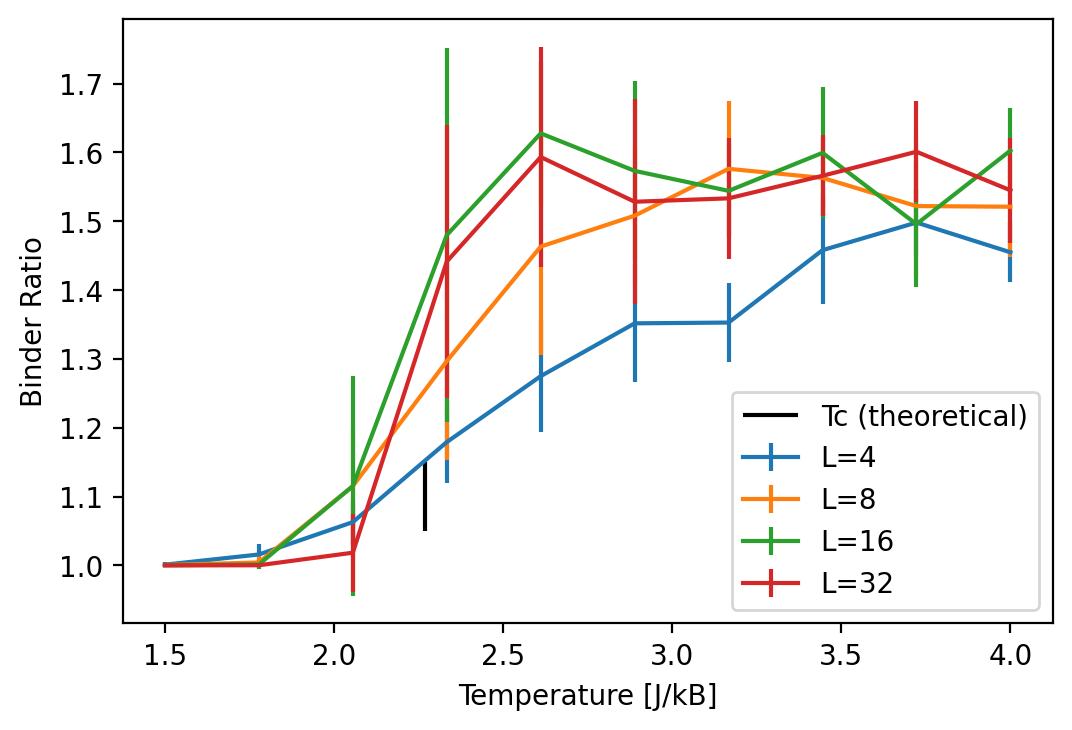

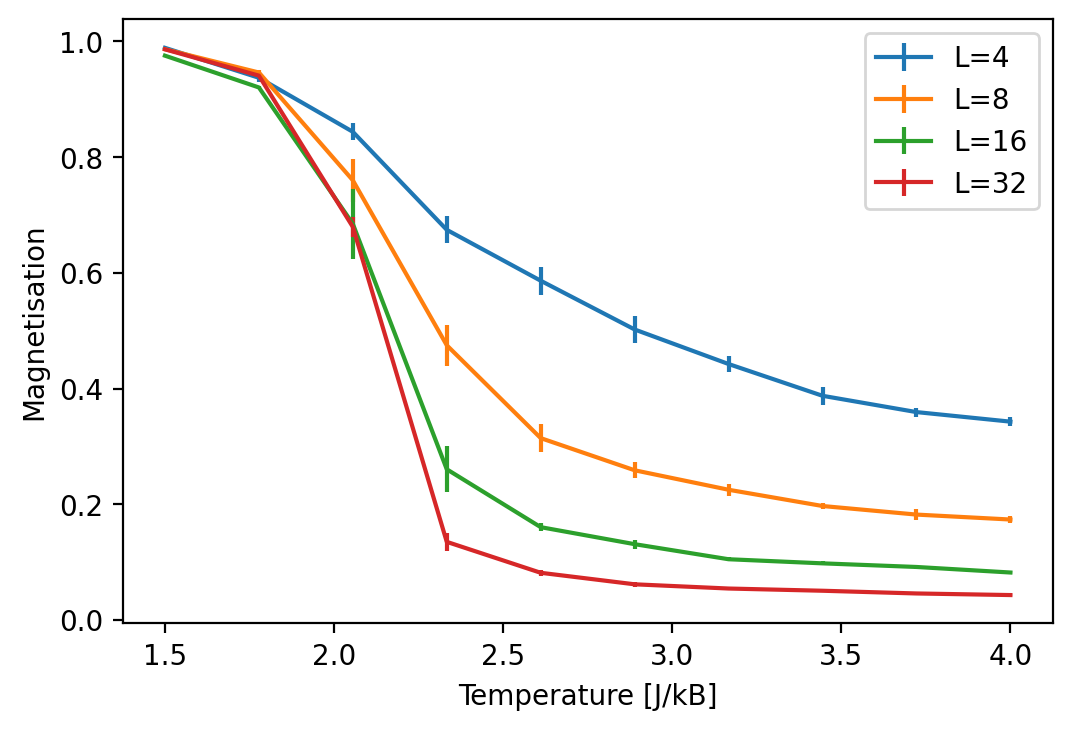

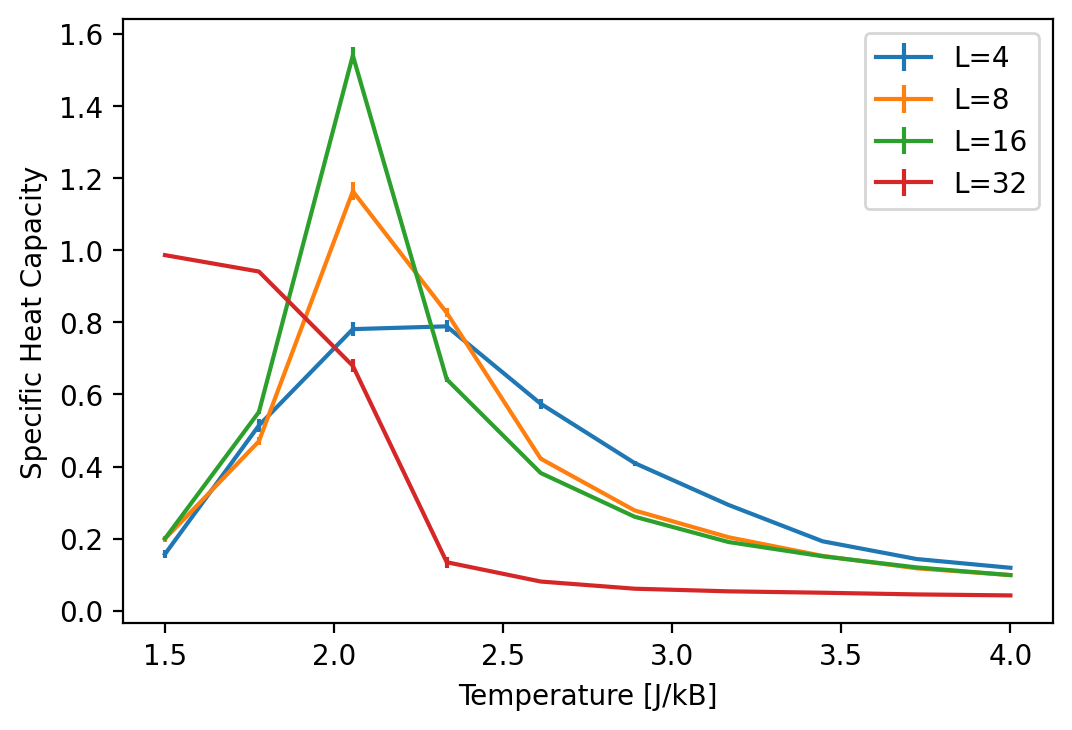

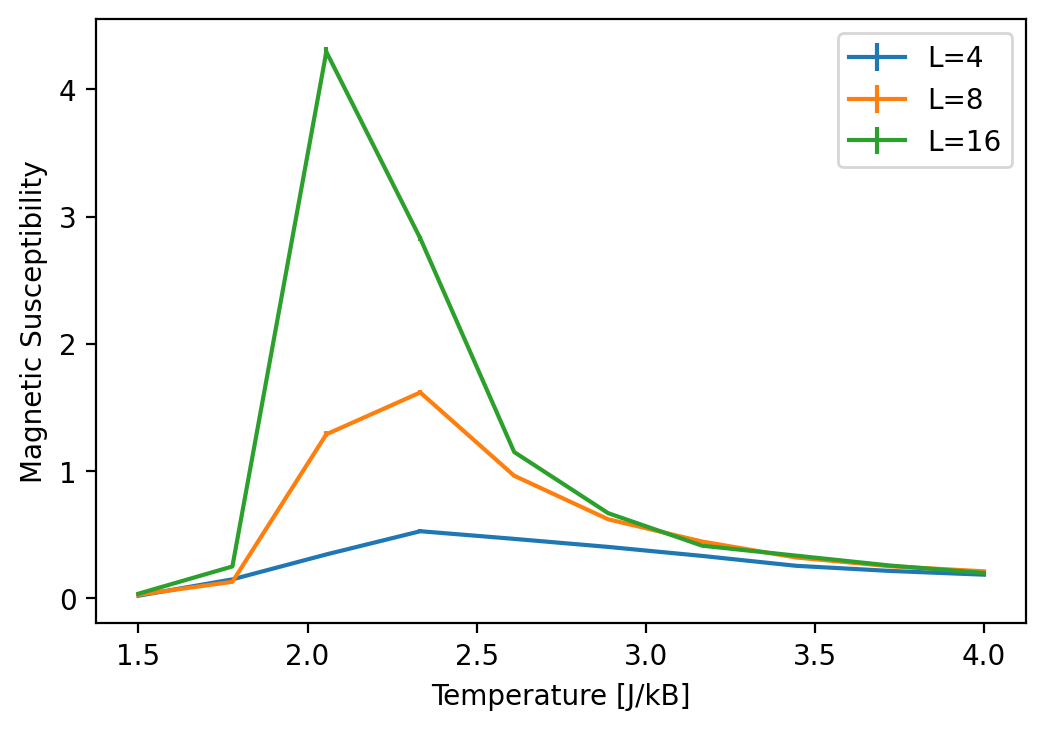

In [ ]:
%matplotlib inline
Tmin = 1.5; Tmax = 4; nt = 10; T = np.linspace(Tmin, Tmax, nt)

plt.figure(dpi=200)
plt.errorbar(T,Q4,yerr=ErrQ4,label = 'L=4')
plt.errorbar(T,Q8,yerr=ErrQ8,label = 'L=8')
plt.errorbar(T,Q16,yerr=ErrQ16,label = 'L=16')
plt.errorbar(T,Q32,yerr=ErrQ32,label = 'L=32')
plt.vlines(2.269185314,1.05,1.15,colors= 'k', label = 'Tc (theoretical)')
plt.ylabel('Binder Ratio')
plt.xlabel('Temperature [J/kB]')
plt.legend()
plt.show()


plt.figure(dpi=200)
plt.errorbar(T,Mag4,yerr=Err_M4,label = 'L=4')
plt.errorbar(T,Mag8,yerr=Err_M8,label = 'L=8')
plt.errorbar(T,Mag16,yerr=Err_M16,label = 'L=16')
plt.errorbar(T,Mag32,yerr=Err_M32,label = 'L=32')
plt.ylabel('Magnetisation')
plt.xlabel('Temperature [J/kB]')
plt.legend()
plt.show()


plt.figure(dpi=200)
plt.errorbar(T,Cv4,yerr=Err_Cv4,label = 'L=4')
plt.errorbar(T,Cv8,yerr=Err_Cv8,label = 'L=8')
plt.errorbar(T,Cv16,yerr=Err_Cv16,label = 'L=16')
plt.errorbar(T,Mag32,yerr=Err_M32,label = 'L=32')
plt.ylabel('Specific Heat Capacity')
plt.xlabel('Temperature [J/kB]')
plt.legend()
plt.show()

plt.figure(dpi=200)
plt.errorbar(T,X4,yerr=Err_X4,label = 'L=4')
plt.errorbar(T,X8,yerr=Err_X8,label = 'L=8')
plt.errorbar(T,X16,yerr=Err_X16,label = 'L=16')
#plt.errorbar(T,Mag32,yerr=Err_M32,label = 'L=32')
plt.ylabel('Magnetic Susceptibility')
plt.xlabel('Temperature [J/kB]')
plt.legend()
plt.show()

In [ ]:
%matplotlib 
plt.style.use("default")
#plt.figure(dpi=400)
fig, axs = plt.subplots(2, 2)
fig.set_dpi(200)
axs[0, 0].errorbar(T,E4,yerr=Err_E4,label = 'L=4')
axs[0, 0].errorbar(T,E8,yerr=Err_E8,label = 'L=8')
axs[0, 0].errorbar(T,E16,yerr=Err_E16,label = 'L=16')
axs[0, 0].errorbar(T,E32,yerr=Err_E32,label = 'L=32')
axs[0, 0].set_title('Energy')
axs[0,0].set_xlabel('')
axs[0, 0].set_ylabel('Energy')
axs[0,0].set_xticks([])
axs[0,0].legend()

axs[0, 1].errorbar(T,Mag4,yerr=Err_M4,label = 'L=4')
axs[0, 1].errorbar(T,Mag8,yerr=Err_M8,label = 'L=8')
axs[0, 1].errorbar(T,Mag16,yerr=Err_M16,label = 'L=16')
axs[0, 1].errorbar(T,Mag32,yerr=Err_M32,label = 'L=32')
axs[0, 1].set_title('Magnetisation')
axs[0,1].set_xlabel('')
axs[0,1].set_ylabel('Magnetisation')
axs[0,1].set_xticks([])
axs[0,1].legend()

axs[1, 0].errorbar(T,Cv4,yerr=Err_Cv4,label = 'L=4')
axs[1, 0].errorbar(T,Cv8,yerr=Err_Cv8,label = 'L=8')
axs[1, 0].errorbar(T,Cv16,yerr=Err_Cv16,label = 'L=16')
axs[1, 0].errorbar(T,Cv32,yerr=Err_Cv32,label = 'L=32')
axs[1, 0].set_title('Specific Heat Capacity')
axs[1,0].set_xlabel('Temperature [J/kB]')
axs[1,0].set_ylabel('Specific Heat Capacity')
axs[1,0].legend()

axs[1, 1].errorbar(T,X4,yerr=Err_X4,label = 'L=4')
axs[1, 1].errorbar(T,X8,yerr=Err_X8,label = 'L=8')
axs[1, 1].errorbar(T,X16,yerr=Err_X16,label = 'L=16')
axs[1, 1].errorbar(T,X32,yerr=Err_X32,label = 'L=32')
axs[1, 1].set_title('Magnetic Susceptibility')
axs[1,1].set_xlabel('Temperature [J/kB]')
axs[1,1].set_ylabel('Magnetic Susceptibility')
axs[1, 1].legend()

Using matplotlib backend: Qt5Agg


In [ ]:
'Higher precision '
nDim = 2 #As before 
Tmin = 2.2
Tmax = 2.3
nt = 2
J = 1
eqSteps = 20
err_runs = 2
mcSteps = 5000
T = np.linspace(Tmin, Tmax, nt)
plot_config = False

start_timeALL = time.time()


L = 8
start_time8 = time.time()
config = init(L,nDim)
Indices = index(L,nDim)
(E8,Mag8,Cv8,X8 ,Err_E8,Err_M8,Q8,ErrQ8) = \
    simulate(config, L,nDim, mcSteps, eqSteps, err_runs,T,plot_config)

end_time8 = time.time()
time8 =  round(end_time8-start_time8,3)
print("L = {} done. took {} seconds".format(L,time8))


L = 16
start_time16 = time.time()
config = init(L,nDim)
Indices = index(L,nDim)
(E16,Mag16,Cv16,X16 ,Err_E16,Err_M16,Q16,ErrQ16) = simulate(config, L,nDim, mcSteps, eqSteps, err_runs,T,plot_config)

end_time16 = time.time()
time16 =  round(end_time16-start_time16,3)
print("L = {} done. took {} seconds".format(L,time16))


L = 20
start_time32 = time.time()
config = init(L,nDim)
Indices = index(L,nDim)
(E32,Mag32,Cv32,X32 ,Err_E32, Err_M32,Q32,ErrQ32) = simulate(config, L,nDim, mcSteps, eqSteps, err_runs,T,plot_config)

end_time32 = time.time()
time32 =  round(end_time32-start_time32,3)
print("L = {} done. took {} seconds".format(L,time32))
end_timeALL = time.time()
timeALL = round(end_timeALL - start_timeALL,3)


L = 25
start_time25 = time.time()
config = init(L,nDim)
Indices = index(L,nDim)
(E25,Mag25,Cv25,X4 ,Err_E25,Err_M25,Q4,ErrQ25) = simulate(config, L,nDim, mcSteps, eqSteps, err_runs,T,plot_config)

end_time25 = time.time()
time25 =  round(end_time25-start_time25,3)
print("L = {} done. took {} seconds".format(L,time25))

print("--- Code took {}s seconds ---".format(timeALL))

In [ ]:
plt.figure(dpi=200)
%matplotlib

plt.errorbar(T,Q8,yerr=ErrQ8,label = 'L=8')
plt.errorbar(T,Q16,yerr=ErrQ16,label = 'L=16')
plt.errorbar(T,Q32,yerr=ErrQ32,label = 'L=2-00....3.3')
plt.errorbar(T,Q4,yerr=ErrQ25,label = 'L=25')
plt.vlines(2.269185314,1.05,1.07,colors= 'k', label = 'Tc (theoretical)')
plt.ylabel('Binder Ratio')
plt.xlabel('Temperature [J/kB]')
plt.legend()
plt.show()

In [ ]:
plt.figure(dpi=200)
plt.errorbar(T,Q4,yerr=ErrQ4,label = 'L=4')
plt.errorbar(T,Q8,yerr=ErrQ8,label = 'L=8')
plt.errorbar(T,Q16,yerr=ErrQ16,label = 'L=16')
#bar(T,Q32,yerr=ErrQ32,label = 'L=32')
plt.vlines(2.269185314,1.05,1.07,colors= 'k', label = 'Tc (theoretical)')
plt.ylabel('Binder Ratio')
plt.xlabel('Temperature [J/kB]')
plt.legend()
plt.show()

In [ ]:
Err_Cv16,Err_X16Err_Cv16,Err_X
plt.figure(dpi=200)
plt.errorbar(T,Q4,yerr=ErrQ4,label = 'L=4')
plt.errorbar(T,Q8,yerr=ErrQ8,label = 'L=8')
plt.errorbar(T,Q16,yerr=ErrQ16,label = 'L=16')
plt.errorbar(T,Q32,yerr=ErrQ32,label = 'L=32')
plt.ylabel('Binder Ratio')
plt.xlabel('Temperature [J/kB]')
plt.legend()
plt.show()


#plt.plot(T,E4,label = "L = 4")
plt.figure(dpi=200)
plt.errorbar(T,E4,yerr=Err_E4,label = 'L=4')
plt.errorbar(T,E8,yerr=Err_E8,label = 'L=8')
plt.errorbar(T,E16,yerr=Err_E16,label = 'L = 16')
plt.errorbar(T,E32,yerr=Err_E32,label = 'L = 32')
plt.vlines(2.269185314,-1,0,colors= 'k', label = 'Tc (theoretical)')
plt.ylabel('Energy per site')
plt.xlabel('Temperature [J/kB]')
plt.legend()
plt.show()

plt.figure(dpi=200)
plt.plot(T,Err_E4, label = 'L = 4' )
plt.plot(T,Err_E8, label = 'L = 8' )
plt.plot(T,Err_E16, label = 'L = 16 ' )
plt.plot(T,Err_E32, label = 'L = 32' )
plt.xlabel('Temperature [J/kB]')
plt.ylabel('Error bar for energy')
plt.legend()
plt.show()

plt.figure(dpi=200)
plt.plot(T,Mag4, label = 'L=4' )
plt.plot(T,Mag8, label = 'L=8' )
plt.plot(T,Mag16, label = 'L=16' )
plt.plot(T,Mag32, label = 'L=32' )
plt.ylabel('Magnetisation')
plt.xlabel('Temperature [J/kB]')
plt.legend()
plt.show()

plt.figure(dpi=200)
plt.plot(T,Cv4, label = 'L=4')
plt.plot(T,Cv8, label = 'L=8')
plt.plot(T,Cv16, label = 'L=16')
plt.plot(T,Cv32, label = 'L=32')
plt.xlabel('Temperature [J/kB]')
plt.ylabel('Specific Heat Capacity')
plt.legend()
plt.show()

plt.figure(dpi=200)
plt.plot(T,X4, label = 'L=4')
plt.plot(T,X8, label = 'L=8')
plt.plot(T,X16, label = 'L=16')
plt.plot(T,X32, label = 'L=32')
plt.xlabel('Temperature [J/kB]')
plt.ylabel('Magnetic Susceptibiltity')
plt.legend()
plt.show()

In [ ]:
#plt.plot(T,E4,label = "L = 4")
plt.figure(dpi=200)
plt.errorbar(T,E4,yerr=Err_E4,label = 'L=4')
plt.errorbar(T,E8,yerr=Err_E8,label = 'L=8')
plt.errorbar(T,E16,yerr=Err_E16,label = 'L = 16')
plt.errorbar(T,E32,yerr=Err_E32,label = 'L = 32')
plt.vlines(2.269185314,-1,0,colors= 'k', label = 'Tc (theoretical)')
plt.ylabel('Energy per site')
plt.xlabel('Temperature [J/kB]')
plt.legend()
plt.show()

plt.figure(dpi=200)
plt.plot(T,Err_E4, label = 'L = 4' )
plt.plot(T,Err_E8, label = 'L = 8' )
plt.plot(T,Err_E16, label = 'L = 16 ' )
plt.plot(T,Err_E32, label = 'L = 32' )
plt.xlabel('Temperature [J/kB]')
plt.ylabel('Error bar for energy')
plt.legend()
plt.show()

plt.figure(dpi=200)
plt.plot(T,Mag4, label = 'L=4' )
plt.plot(T,Mag8, label = 'L=8' )
plt.plot(T,Mag16, label = 'L=16' )
plt.plot(T,Mag32, label = 'L=32' )
plt.ylabel('Magnetisation')
plt.xlabel('Temperature [J/kB]')
plt.legend()
plt.show()

plt.figure(dpi=200)
plt.plot(T,Cv4, label = 'L=4')
plt.plot(T,Cv8, label = 'L=8')
plt.plot(T,Cv16, label = 'L=16')
plt.plot(T,Cv32, label = 'L=32')
plt.xlabel('Temperature [J/kB]')
plt.ylabel('Specific Heat Capacity')
plt.legend()
plt.show()

plt.figure(dpi=200)
plt.plot(T,X4, label = 'L=4')
plt.plot(T,X8, label = 'L=8')
plt.plot(T,X16, label = 'L=16')
#plt.plot(T,X32, label = 'L=32')
plt.xlabel('Temperature [J/kB]')
plt.ylabel('Magnetic Susceptibiltity')
plt.legend()
plt.show()

In [ ]:
'Store the Data in Data.csv'

with open('Data.csv', 'w', newline='') as csvfile:

    writer = csv.writer(csvfile)
    
    writer.writerow(["Temperatures"])
    writer.writerow(T)
    writer.writerow([])

    writer.writerow(["Energies"])
    writer.writerow(E4)
    writer.writerow(E8)
    writer.writerow(E16)
    writer.writerow(E32)
    writer.writerow([])
    
    writer.writerow(["Magnetisation"])
    writer.writerow(Mag4)
    writer.writerow(Mag8)
    writer.writerow(Mag16)
    writer.writerow(Mag32)
    writer.writerow([])
    
    writer.writerow(["Specific Heats"])
    writer.writerow(Cv4)
    writer.writerow(Cv8)
    writer.writerow(Cv16)
    writer.writerow(Cv32)
    writer.writerow([])

    writer.writerow(["Susceptibilities"])
    writer.writerow(X4)
    writer.writerow(X8)
    writer.writerow(X16)
    writer.writerow(X32)
    writer.writerow([])
    
    writer.writerow(["Error Energies"])
    writer.writerow(Err_E4)
    writer.writerow(Err_E8)
    writer.writerow(Err_E16)
    writer.writerow(Err_E32)
    writer.writerow([])

    writer.writerow(["Error Magnetisation"])
    writer.writerow(Err_M4)
    writer.writerow(Err_M8)
    writer.writerow(Err_M16)
    writer.writerow(Err_M32)
    writer.writerow([])

    writer.writerow(["Error Cv"])
    writer.writerow(Err_Cv4)
    writer.writerow(Err_Cv8)
    writer.writerow(Err_Cv16)
    writer.writerow(Err_Cv32)
    writer.writerow([])

    writer.writerow(["Error X"])
    writer.writerow(Err_X4)
    writer.writerow(Err_X8)
    writer.writerow(Err_X16)
    writer.writerow(Err_X32)
    writer.writerow([])
    
    writer.writerow(["Binder Ratio"])
    writer.writerow(Q4)
    writer.writerow(Q8)
    writer.writerow(Q16)
    writer.writerow(Q32)
    writer.writerow([])

    writer.writerow(["Error Binder"])
    writer.writerow(ErrQ4)
    writer.writerow(ErrQ8)
    writer.writerow(ErrQ16)
    writer.writerow(ErrQ32)
    writer.writerow([])

In [ ]:
%matplotlui%%hgfcghcdsdssdssdssdsErr_E4max = (max(Err_E4)*4)
Err_E8max = max(Err_E8)*8
Err_E16max = (max(Err_E16)*16)
Err_E32max = max(Err_E32)*32

In [ ]:
'Using Binder Ratios around the Critical Point '
'L = 4,8,16'
nDim =2 

J = 1
eqSteps = 200; mcSteps = 10000; err_runs = 1
plot_config = False 
T = [2.2,2.25,2.3]

L = 8
config = init(L,nDim)
Indices = index(L,nDim)
(E_8,Mag_8,Cv_8,X_8 ,Err_E_8,Err_M_8,Err_Cv_8,Err_X_8,Q_8,ErrQ_8) = simulate(config, L,nDim, mcSteps, eqSteps, err_runs,T,plot_config)
print("L = 8 done")

L = 16
config = init(L,nDim)
Indices = index(L,nDim)
(E_16,Mag_16,Cv_16,X_16 ,Err_E_16,Err_M_16,Err_Cv_16,Err_X_16,Q_16,ErrQ_16) = simulate(config, L,nDim, mcSteps, eqSteps, err_runs,T,plot_config)
print("L = 16 done")

L = 32
config = init(L,nDim)
Indices = index(L,nDim)
(E_4,Mag_4,Cv_4,X_4 ,Err_E_4,Err_M_4,Err_Cv_4,Err_X_4,Q_4,ErrQ_4) = simulate(config, L,nDim, mcSteps, eqSteps, err_runs,T,plot_config)
print("L = 32 done")

L = 4 done
L = 8 done
L = 16 done


In [ ]:
%matplotlib
print(ErrQ_4)
plt.figure(dpi=200)
plt.errorbar(T,Q_8,yerr=ErrQ_8,label = 'L=8')
plt.errorbar(T,Q_16,yerr=ErrQ_16,label = 'L=16')
plt.errorbar(T,Q_4,yerr=ErrQ_4,label = 'L=32')
plt.vlines(2.269185314,1.04,1.1,colors= 'k', label = 'Tc (theoretical)')
plt.ylabel('Binder Ratio')
plt.xlabel('Temperature')
plt.legend()
plt.show()


Using matplotlib backend: Qt5Agg
[0.0274951  0.03595819 0.14113854]


In [ ]:
'Getting real close to the Critical Point '

nDim =2 ; J = 1
eqSteps = 2000; mcSteps = 10000; err_runs = 1
plot_config = False 
T = [2.25,2.3]

L = 40
config = init(L,nDim)
Indices = index(L,nDim)
(E_40,M40,Cv40,X40 ,Err_E40,Err_M40,Err_Cv40,Err_X40,Q_40,ErrQ40) = simulate(config, L,nDim, mcSteps, eqSteps, err_runs,T,plot_config)
print("L = 40 done")

T = [2.25,2.31]
L = 50
config = init(L,nDim)
Indices = index(L,nDim)
(E_50,M0,Cv50,X50 ,Err_E50,Err_M50,Err_Cv50,Err_X50,Q_50,ErrQ50) = simulate(config, L,nDim, mcSteps, eqSteps, err_runs,T,plot_config)
print("L = 50 done")

L = 64
T = [2.25,2.32]
config = init(L,nDim)
Indices = index(L,nDim)
(E64,M4,Cv64,X64 ,Err_E64,Err_M64,Err_Cv64,Err_X64,Q64,ErrQ64) = simulate(config, L,nDim, mcSteps, eqSteps, err_runs,T,plot_config)
print("L = 64 done")

L = 40 done
L = 50 done
L = 64 done


In [ ]:
%matplotlib
plt.style.use("seaborn-dark")
T_c = 2/math.log(1 + math.sqrt(2)) #Theoretical Critical Temperature
print(T_c)
t = [temp/T_c for temp in T]

plt.figure(dpi=200)
plt.errorbar(t,Q_40,yerr=ErrQ40,label = 'L=40')
plt.errorbar(t,Q_50,yerr=ErrQ50,label = 'L=50')
plt.errorbar(t,Q64,yerr=ErrQ64,label = 'L=64')
#plt.vlines(T_c,1.0,1.1,colors= 'k', label = 'Tc (theoretical)')
plt.ylabel('Binder Ratio')
plt.xticks()
plt.yticks()
plt.xlabel('T/Tc')
plt.legend()
plt.show()

Using matplotlib backend: Qt5Agg
2.269185314213022


NameError: name 'T' is not defined

In [ ]:
'Attempt for nDim = 3'

' L = 4,8,16 & 32 '
J = 1; nDim = 3; plot_config = False #As before 
Tmin = 1.5; Tmax = 5; nt = 10; T = np.linspace(Tmin, Tmax, nt)
eqSteps = 200; err_runs = 5; mcSteps = 10000

config = init(L,nDim)
Indices = index(L,nDim)

start_time43 = time.time()
(E3,Mag3,Cv3,X3,Err_E3,Err_M_3,Q_3,ErrQ_3) = \
    simulate(config, L,nDim, mcSteps, eqSteps, err_runs,T, plot_config = True)

end_time43 = time.time()
time43 =  round(end_time43-start_time43,3)
print("nDim =3, L = {} done. took {} seconds".format(L,time43))
plt.errorbar(T,E3,yerr=Err_E,)
#plt.errorbar(T,E,yerr=Erik)
plt.ylabel('Energy')
plt.xlabel('Temperature [Kb/J]')
plt.show()

plt.plot(T,Err_E3, label = 'L = 4')
plt.ylabel('Energy Error Bar')
plt.xlabel('Temperature [Kb/J]')
plt.legend()
plt.show()

plt.plot(T,Mag3, label = 'L = 4')
plt.ylabel('Magnetisation')
plt.xlabel('Temperature [Kb/J]')
plt.legend()
plt.show()

<ipython-input-1-28f8bcc20e21>:248: RuntimeWarning: overflow encountered in long_scalars
  M_squared += mag**2
